In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import os
import os.path as path
import seaborn as sns
import re

import theano
import pymc3 as pm
from pymc3.model_graph import ModelGraph, model_to_graphviz
from pymc3 import glm

import matplotlib.image as mpimg

from scipy import stats

from utils import kde_scatter


sns.reset_orig()

%matplotlib inline
%load_ext autoreload

%autoreload 2
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams["font.size"] = "24"
sns.set(font_scale=1.5)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

In [2]:
DATAPATH = 'EEVEE-data.pkl'

In [3]:
def summary(trace, varnames=None):
    pm.plot_posterior(trace, varnames=varnames)
    plt.show()
    pm.plots.traceplot(trace, varnames=varnames)
    plt.show()
    pm.plots.forestplot(trace, varnames=varnames)
    plt.show()
    if varnames is None:
        pm.plots.energyplot(trace)
        plt.show()
        print('Gelman-Rubin ', max(np.max(gr_values) for gr_values in pm.gelman_rubin(trace).values()))
    return pm.summary(trace, varnames=varnames)

In [4]:
def domaine_to_int(x):
    if x is None:
        return 0
    else:
        return int(x)

In [5]:
df = pd.read_pickle(DATAPATH)
df[('ProfilJeuxVideo', 'travaillez_vous_dans_le_domaine_cb_de_temps')] = df[('ProfilJeuxVideo', 'travaillez_vous_dans_le_domaine_cb_de_temps')].apply(domaine_to_int)

In [6]:
participants = np.sort(df.participant.unique())
num_participant = len(df.participant.unique())

avatars = np.sort(df.avatar.unique())
num_avatar = len(df.avatar.unique())

# Statistics

In [7]:
numeric = list(df.mean().index)
non_numeric = [x for x in df.columns if x not in numeric]

In [8]:
df[['age', 'genre', 'realisme', 'avatar']].groupby('avatar').describe().drop('avatar', axis=1)

age                                                        genre  \
                                                                             
        count       mean       std   min    25%   50%    75%    max  count   
avatar                                                                       
1       242.0  23.322314  6.805191  11.0  17.00  23.0  28.00   45.0  242.0   
2       242.0  25.834711  7.179786  12.0  20.00  25.0  30.00   52.0  242.0   
3       242.0  24.004132  5.873139  14.0  20.00  23.0  27.00   68.0  242.0   
4       242.0  30.227273  4.910189  20.0  27.00  30.0  33.00   46.0  242.0   
5       242.0  44.661157  9.032494  16.0  40.00  45.0  50.00   93.0  242.0   
6       242.0  49.987603  8.170629  25.0  45.00  50.0  55.00   77.0  242.0   
7       242.0  40.690083  6.255871  26.0  36.00  40.0  45.00   68.0  242.0   
8       242.0  39.264463  6.084152  17.0  35.00  40.0  44.00   55.0  242.0   
9       242.0  62.285124  9.037342  38.0  55.25  62.0  68.00   86.0  242.0   
10      242.0  72.309917  8.770886  42.0  65.00  73.0  79.00   91.0  242.0   
11      242.0  65.466942  9.788688  45.0  58.00  65.0  70.75   95.0  242.0   
12      242.0  66.809917  7.455889  50.0  61.00  65.0  71.00   90.0  242.0   
13      242.0  79.165289  7.354505  52.0  75.00  80.0  85.00  100.0  242.0   
14      242.0  66.690083  8.483755  38.0  61.25  66.0  72.00  100.0  242.0   
15      242.0  66.322314  8.891429  45.0  60.00  65.0  72.00   95.0  242.0   
16      242.0  74.392562  8.119365  55.0  70.00  75.0  80.00   93.0  242.0   

                                                                 realisme  \
                                                                            
             mean        std   min     25%    50%     75%    max    count   
avatar                                                                      
1       46.132231  40.710075   0.0    0.00   44.5   92.75  100.0    242.0   
2       15.095041  26.281655   0.0    0.00    0.0   19.00  100.0    242.0   
3       98.033058   5.632499  50.0   99.25  100.0  100.00  100.0    242.0   
4       98.066116   5.294224  58.0   99.00  100.0  100.00  100.0    242.0   
5        8.004132  17.336431   0.0    0.00    0.0    5.00  100.0    242.0   
6       14.475207  24.342333   0.0    0.00    0.0   20.75  100.0    242.0   
7       97.938017   5.940951  50.0  100.00  100.0  100.00  100.0    242.0   
8       97.838843   6.545314  47.0   99.25  100.0  100.00  100.0    242.0   
9        7.690083  16.010598   0.0    0.00    0.0    9.75  100.0    242.0   
10       4.177686  12.125444   0.0    0.00    0.0    2.00  100.0    242.0   
11      97.421488   6.918317  50.0   99.00  100.0  100.00  100.0    242.0   
12      97.074380   9.646589   4.0   99.25  100.0  100.00  100.0    242.0   
13       3.318182  11.576643   0.0    0.00    0.0    1.00  100.0    242.0   
14      15.578512  25.489645   0.0    0.00    0.0   24.00  100.0    242.0   
15      97.235537   9.198948   0.0   99.00  100.0  100.00  100.0    242.0   
16      96.954545   7.295340  50.0   98.00  100.0  100.00  100.0    242.0   

                                                              
                                                              
             mean        std  min    25%   50%    75%    max  
avatar                                                        
1       51.260331  24.765171  0.0  35.25  53.5  69.00  100.0  
2       49.623967  25.616448  0.0  33.25  53.0  67.00  100.0  
3       74.859504  20.444564  8.0  64.00  77.0  92.00  100.0  
4       62.714876  22.655944  3.0  48.00  63.5  81.75  100.0  
5       45.698347  23.625798  0.0  31.25  43.0  64.00   99.0  
6       44.880165  23.456106  0.0  33.00  42.0  60.00  100.0  
7       46.438017  25.608088  0.0  28.00  43.5  66.75  100.0  
8       61.962810  22.789190  0.0  46.25  62.0  80.00  100.0  
9       54.913223  24.112218  0.0  38.00  57.0  72.75  100.0  
10      61.504132  21.009432  0.0  50.00  64.0  76.75  100.0  
11      68.541322  20.9672

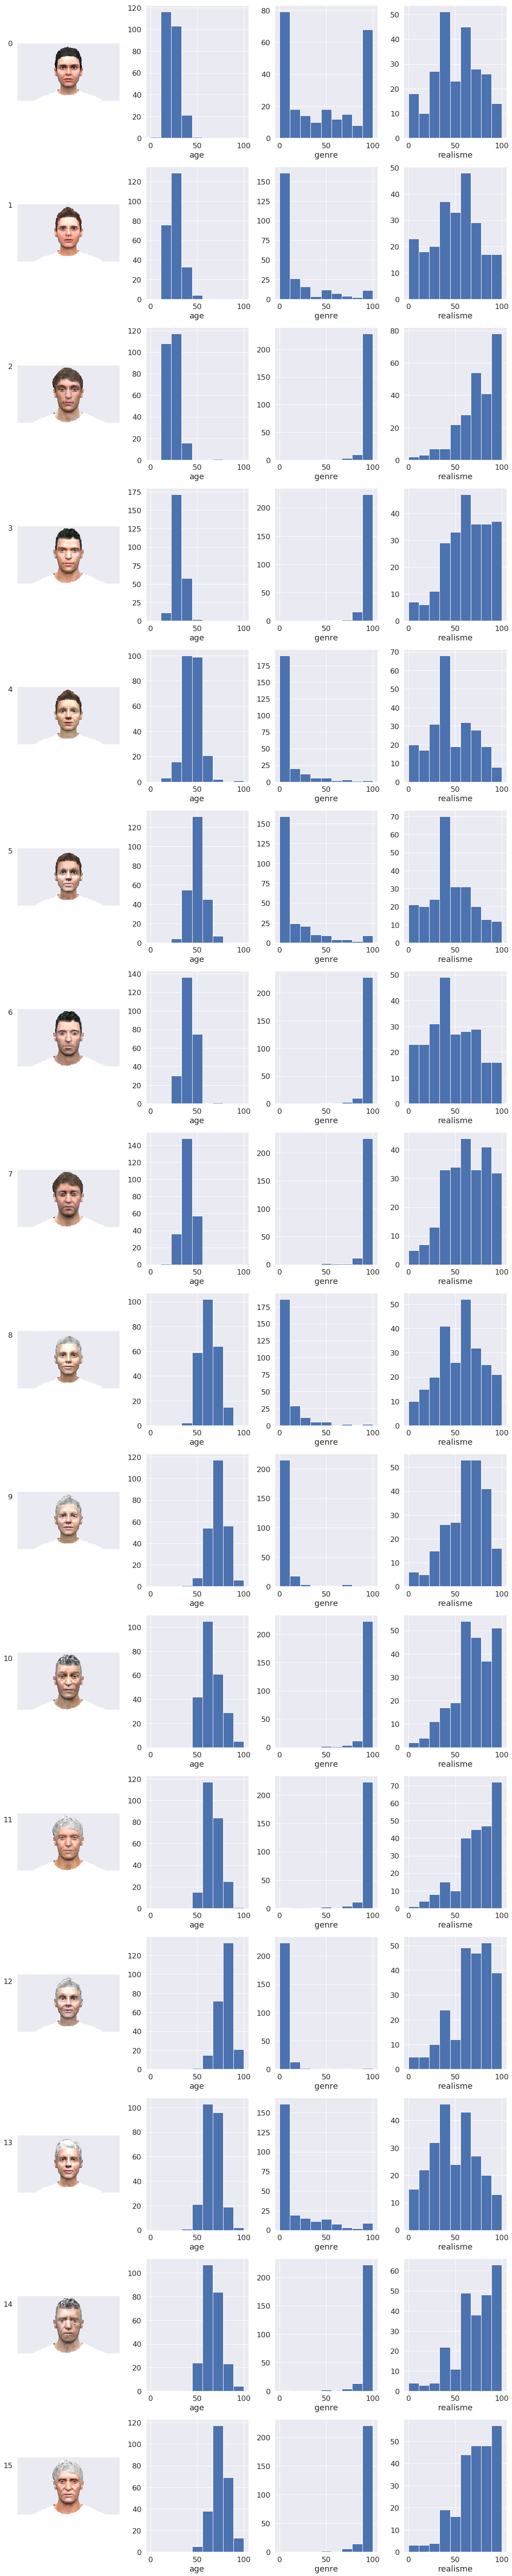

In [9]:
fig = plt.figure(figsize=(16,80))
for idx, avatar in enumerate(avatars[:]):
    plt.subplot(num_avatar, 4, 4*idx+1)
    img=mpimg.imread('images/{}.png'.format(avatar))
    imgplot = plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([avatar-1])
    
    plt.subplot(num_avatar, 4, 4*idx+2)
    df[df.avatar==avatar].age.hist(bins=np.linspace(0, 100, 10))
    plt.xlabel('age')

    
    plt.subplot(num_avatar, 4, 4*idx+3)
    df[df.avatar==avatar].genre.hist(bins=np.linspace(0, 100, 10))
    plt.xlabel('genre')

    plt.subplot(num_avatar, 4, 4*idx+4)
    df[df.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10))
    plt.xlabel('realisme')
plt.tight_layout()
plt.savefig('Avatar Histogramme.png', dpi=120)
plt.show()

## difference between men and women

In [10]:
df[['age', 'genre', 'realisme', 'male']].groupby('male').describe()
print(scipy.stats.ttest_ind(df[df.male].age.dropna(), df[~df.male].age.dropna()))

Ttest_indResult(statistic=-1.8426309550233257, pvalue=0.065459353679067064)


## Influence of age of participant

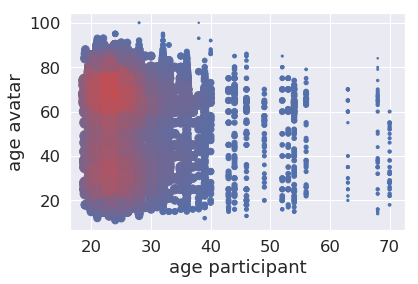

In [11]:
kde_scatter(df['age_participant'], df['age'])

plt.ylabel('age avatar')
plt.xlabel('age participant')
plt.show()

In [12]:
df_age = df[['age_participant', 'age']].dropna()
r, p = scipy.stats.pearsonr(df_age['age'], df_age['age_participant'])
print('pearson r:{:0.3f}, p:{:0.6f}'.format(r, p))
r, p = scipy.stats.spearmanr(df_age['age'], df_age['age_participant'])
print('spearman r:{:0.3f}, p:{:0.6f}'.format(r, p))

pearson r:-0.075, p:0.000003
spearman r:-0.061, p:0.000139


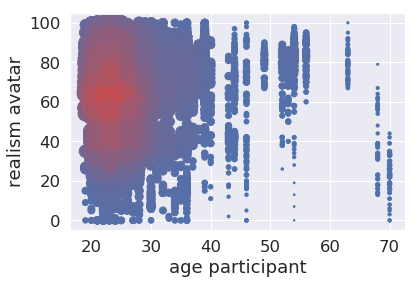

In [13]:
kde_scatter(df['age_participant'].values, df['realisme'].values)
plt.ylabel('realism avatar')
plt.xlabel('age participant')
plt.show()

In [14]:
df_real = df[['age_participant', 'realisme']].dropna()
r, p = scipy.stats.pearsonr(df_real['realisme'], df_real['age_participant'])
print('pearson r:{:0.3f}, p:{:0.6f}'.format(r, p))
r, p = scipy.stats.spearmanr(df_real['realisme'], df_real['age_participant'])
print('spearman r:{:0.3f}, p:{:0.6f}'.format(r, p))

pearson r:-0.012, p:0.453758
spearman r:-0.001, p:0.951603


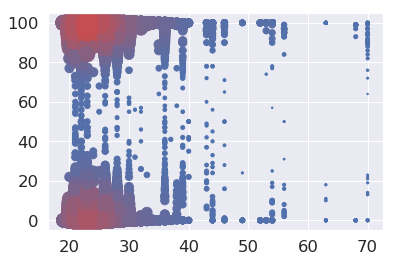

In [15]:
df_genre = df[['age_participant', 'genre']].dropna().copy()
kde_scatter(df_genre['age_participant'].values, df_genre['genre'].values)
plt.show()

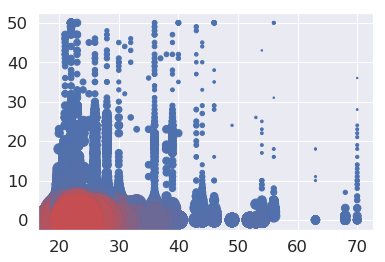

In [16]:
df_genre['ambiguity'] = -(df_genre.genre - 50).abs() + 50
kde_scatter(df_genre['age_participant'].values, df_genre['ambiguity'].values)
plt.show()

In [17]:
r, p = scipy.stats.pearsonr(df_genre['ambiguity'], df_real['age_participant'])
print('pearson r:{:0.3f}, p:{:0.6f}'.format(r, p))
r, p = scipy.stats.spearmanr(df_genre['ambiguity'], df_real['age_participant'])
print('spearman r:{:0.3f}, p:{:0.6f}'.format(r, p))

pearson r:0.054, p:0.000755
spearman r:0.064, p:0.000065


# Bayesian analysis

In [18]:
age_obs_data = np.zeros((num_avatar, num_participant, 2)) * np.nan
for idx, avatar in enumerate(avatars):
    for jdx, par in enumerate(participants):
        age_obs_data[idx, jdx, :] = df[(df.participant==par) & (df.avatar==avatar) & df.age_trial].age.values
        
genre_obs_data = np.zeros((num_avatar, num_participant, 2)) * np.nan
for idx, avatar in enumerate(avatars):
    for jdx, par in enumerate(participants):
        genre_obs_data[idx, jdx, :] = df[(df.participant==par) & (df.avatar==avatar) & df.age_trial].genre.values
        
realisme_obs_data = np.zeros((num_avatar, num_participant, 2)) * np.nan
for idx, avatar in enumerate(avatars):
    for jdx, par in enumerate(participants):
        realisme_obs_data[idx, jdx, :] = df[(df.participant==par) & (df.avatar==avatar) & df.realism_trial].realisme.values[:2]
        
genre_obs = np.clip(genre_obs_data.reshape((num_avatar, -1))/100, 0.01, 0.99) # Clinping genre information to fit a beta distribution

## Simple model

### Age

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_avatars_age, μ_avatars_age]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:07<00:00, 1309.17draws/s]


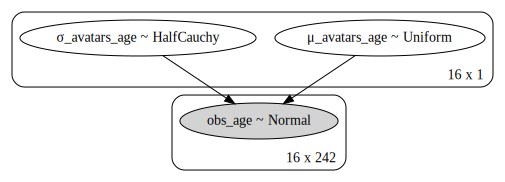

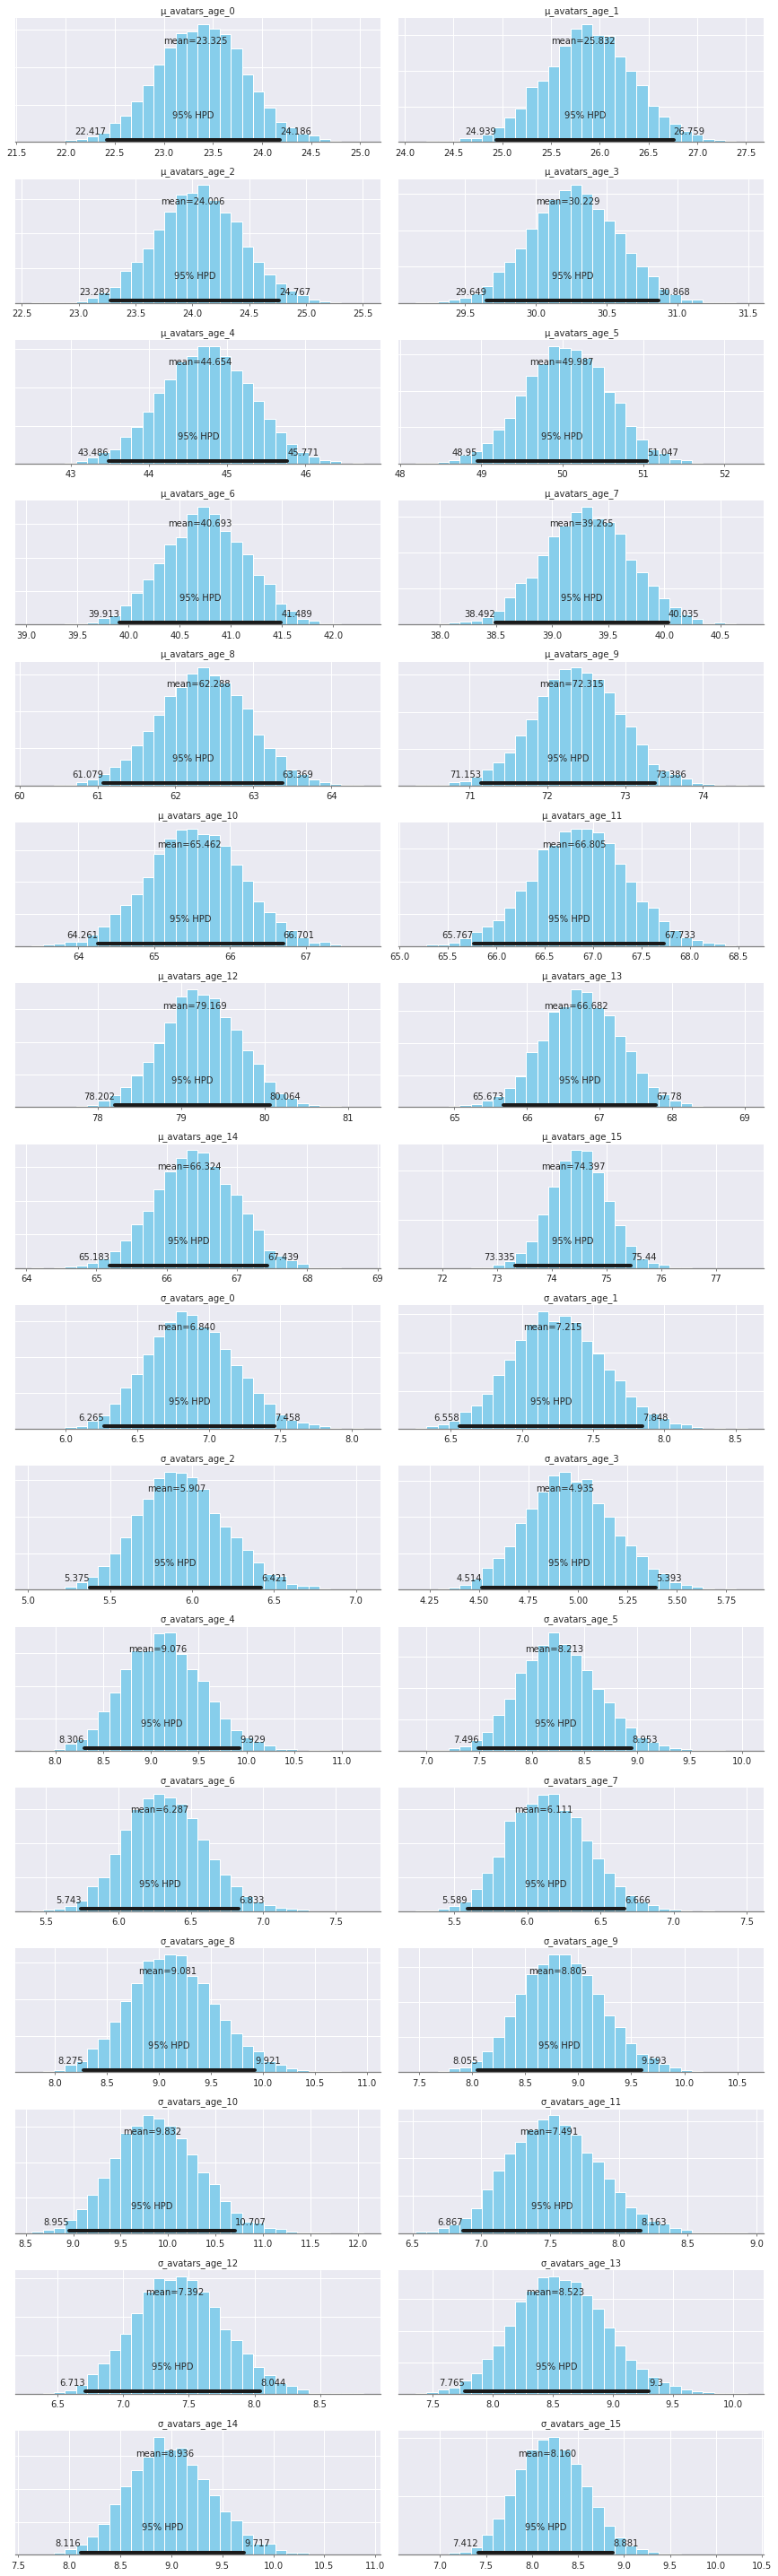

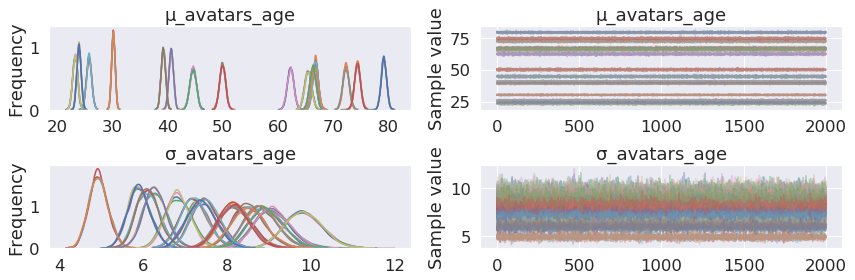

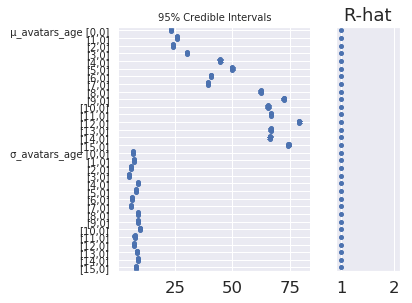

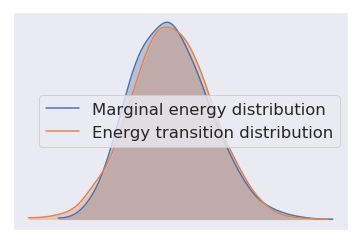

Gelman-Rubin  1.00003663827


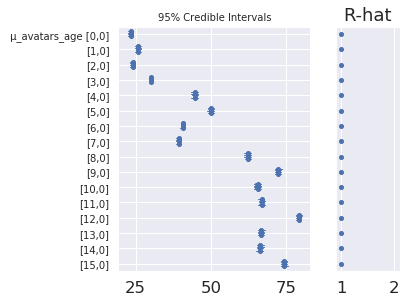

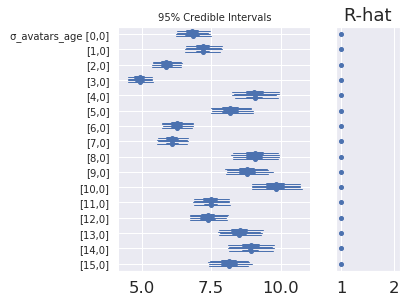

In [19]:
with pm.Model() as model_simple_age:
    # Age
    ## priors
    μ_avatars_age = pm.Uniform('μ_avatars_age', 0, 100, shape=(num_avatar,1))
    σ_avatars_age = pm.HalfCauchy('σ_avatars_age', 25, shape=(num_avatar,1))
    
    ## obsevations
    obs_age = pm.Normal('obs_age', 
                        mu=μ_avatars_age, 
                        sd=σ_avatars_age, 
                        shape=(num_avatar, 1), 
                        observed=age_obs_data.reshape((num_avatar, -1)))

    trace = pm.sample(draws=2000, cores=4)

display(model_to_graphviz(model_simple_age))
summary(trace)
pm.plots.forestplot(trace, varnames=['μ_avatars_age'])
plt.show()
pm.plots.forestplot(trace, varnames=['σ_avatars_age'])
plt.show()

### Genre

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_avatars_genre, α_avatars_genre]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:08<00:00, 1239.91draws/s]


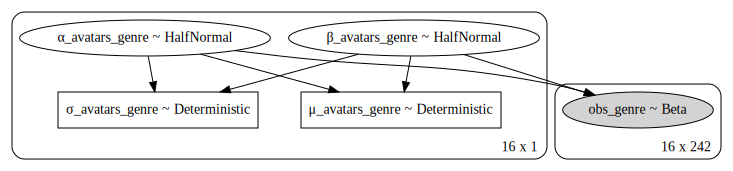

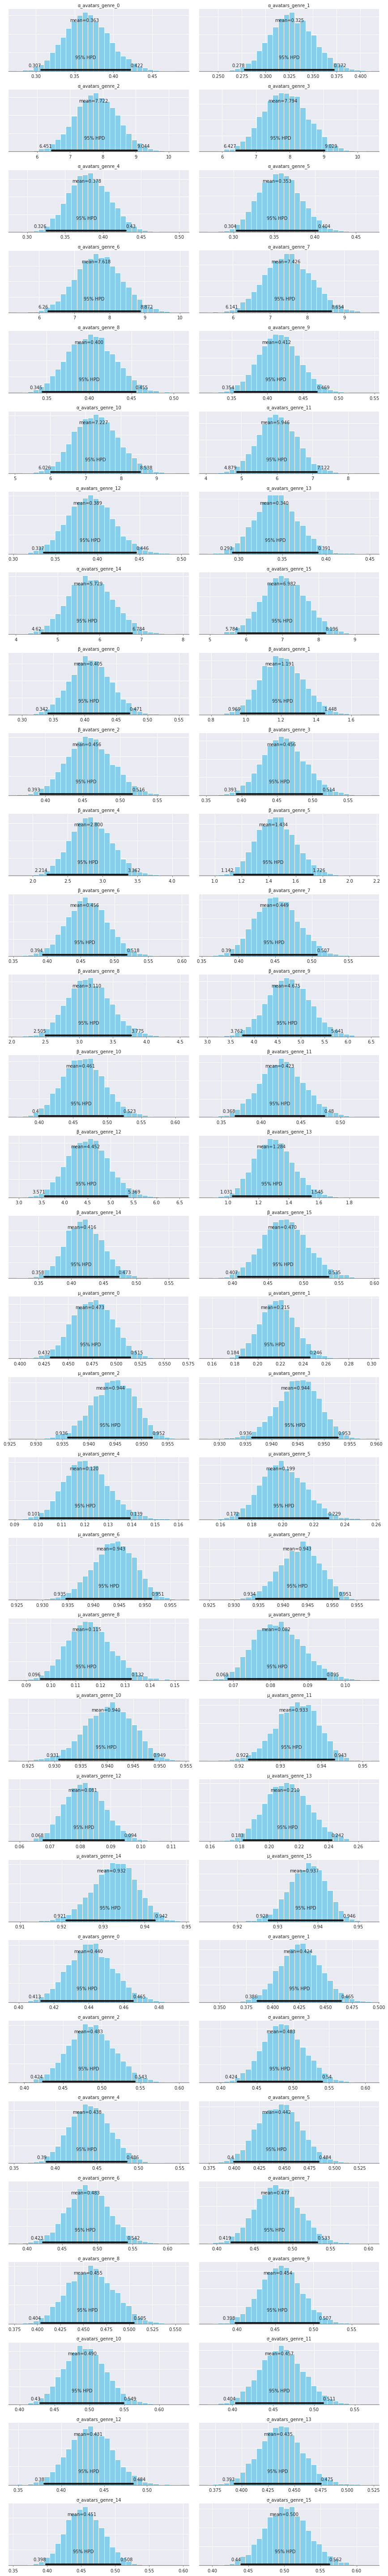

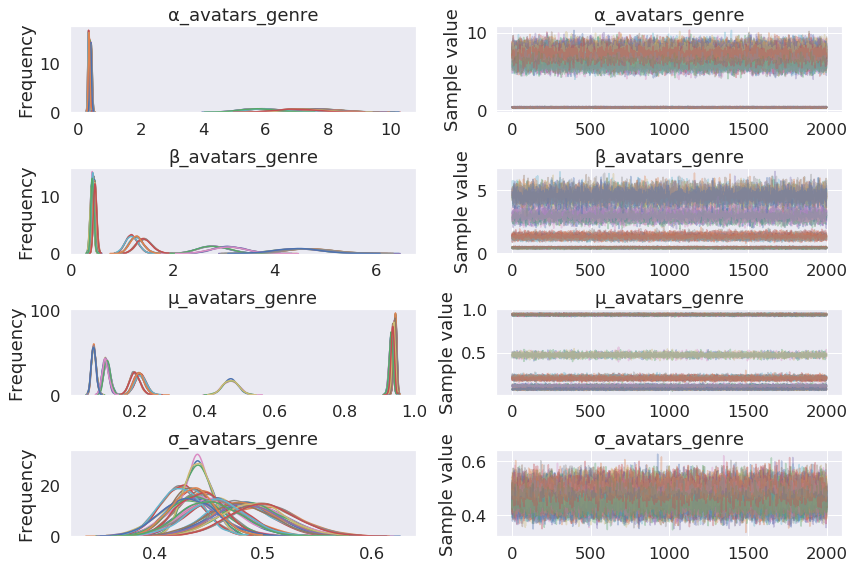

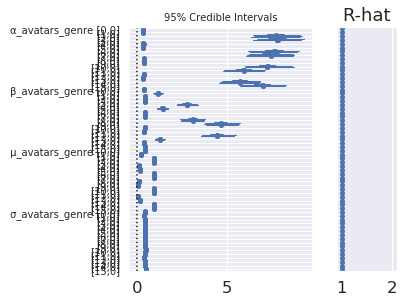

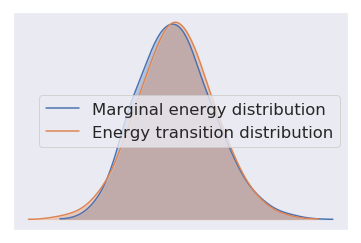

Gelman-Rubin  1.00027087403


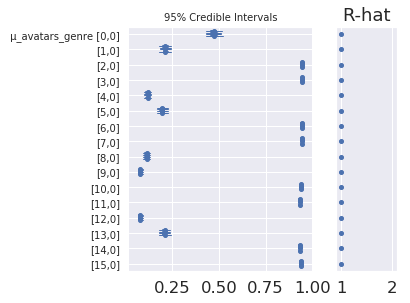

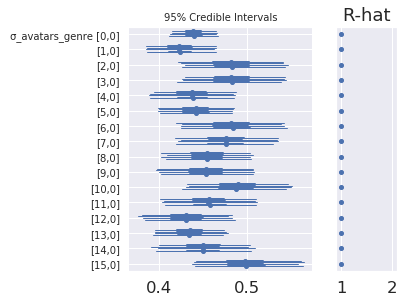

In [20]:
with pm.Model() as model_simple_genre:
    # genre
    ## priors
    α_avatars_genre = pm.HalfNormal('α_avatars_genre', 1, shape=(num_avatar,1))
    β_avatars_genre = pm.HalfNormal('β_avatars_genre', 1, shape=(num_avatar,1))
    
    μ_avatars_genre = pm.Deterministic('μ_avatars_genre', α_avatars_genre/(α_avatars_genre+β_avatars_genre))
    σ_avatars_genre = pm.Deterministic('σ_avatars_genre',
                                       α_avatars_genre*β_avatars_genre/((α_avatars_genre+β_avatars_genre)**2)*(α_avatars_genre+β_avatars_genre+1))
        
    ## obsevations
    obs_genre = pm.Beta('obs_genre',
                          alpha=α_avatars_genre, 
                          beta=β_avatars_genre,
                          shape=(num_avatar, 1),
                          observed=genre_obs)    

    trace = pm.sample(draws=2000, cores=4)


display(model_to_graphviz(model_simple_genre))
summary(trace) 
pm.plots.forestplot(trace, varnames=['μ_avatars_genre'])
plt.show()
pm.plots.forestplot(trace, varnames=['σ_avatars_genre'])
plt.show()

trace_simple_genre = trace

### Realisme

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_avatars_realisme, μ_avatars_realisme]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:07<00:00, 1379.42draws/s]


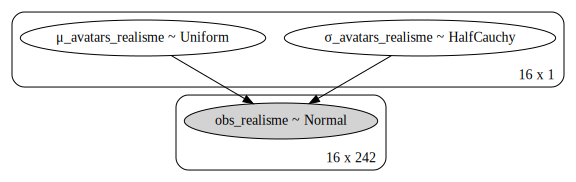

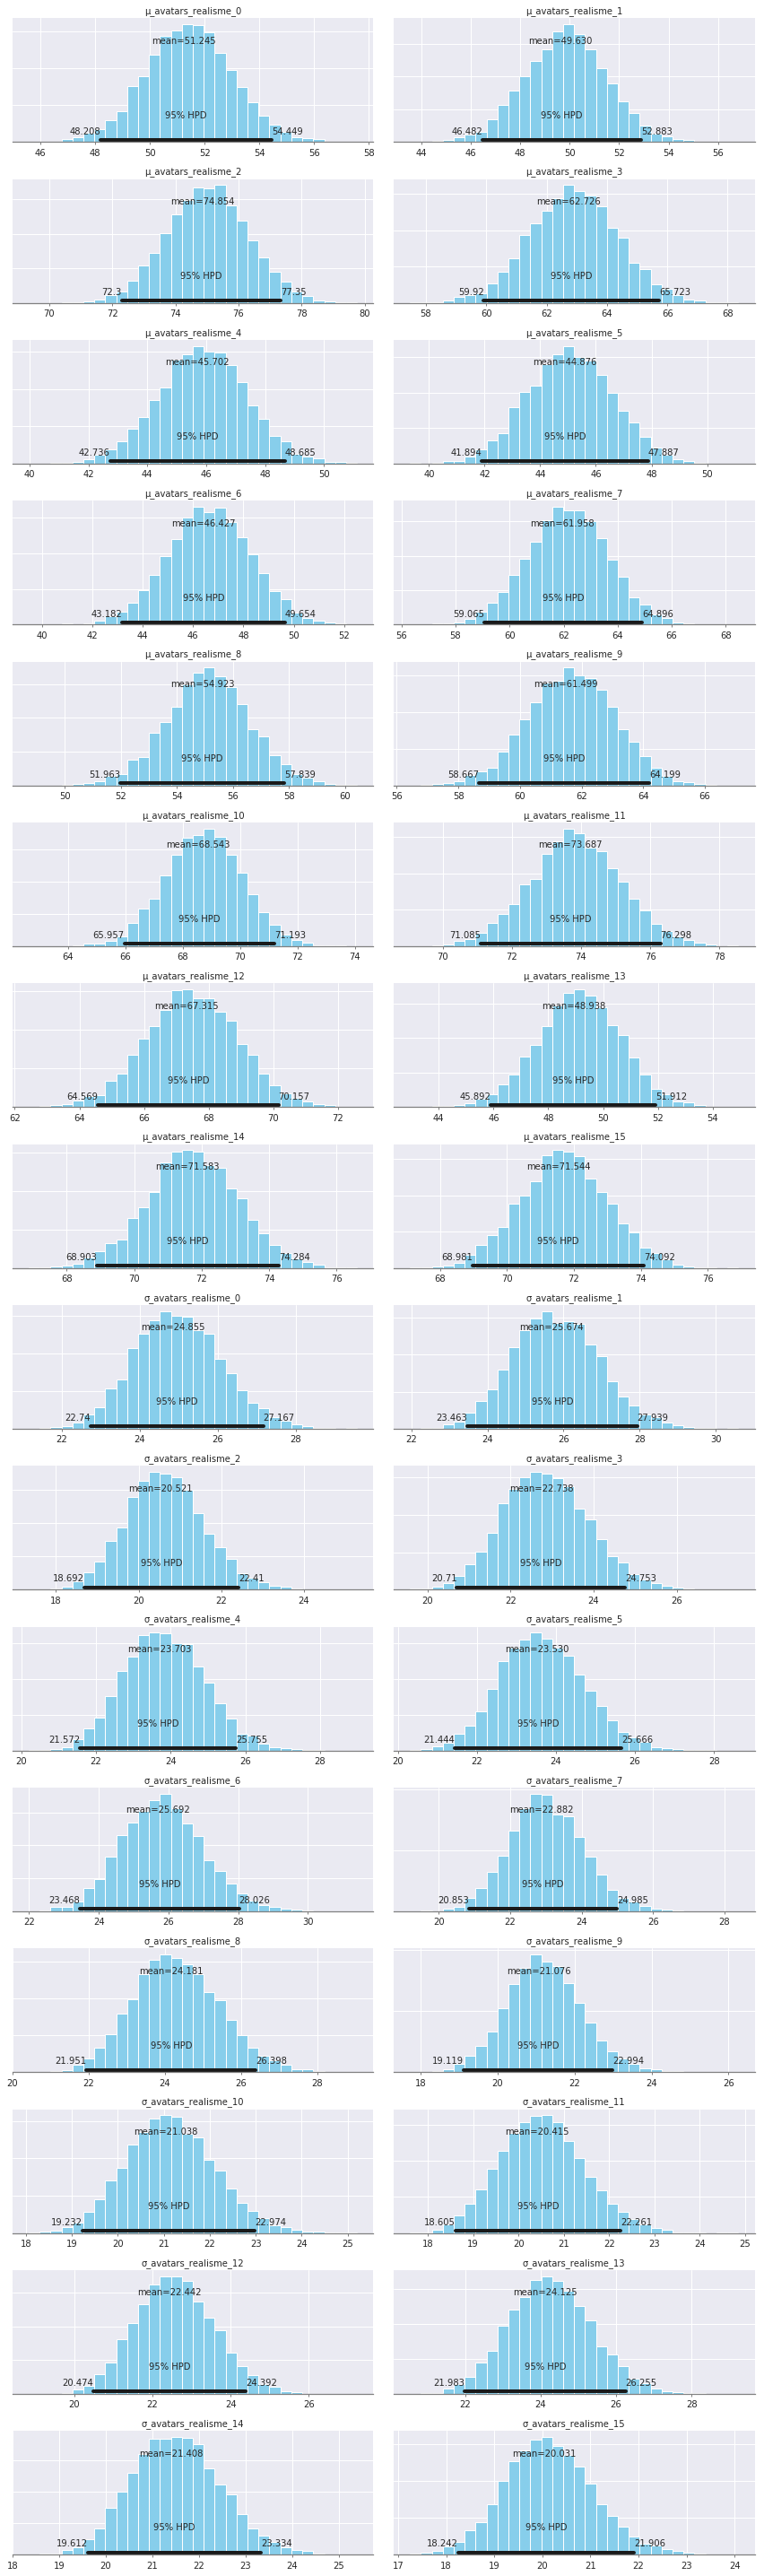

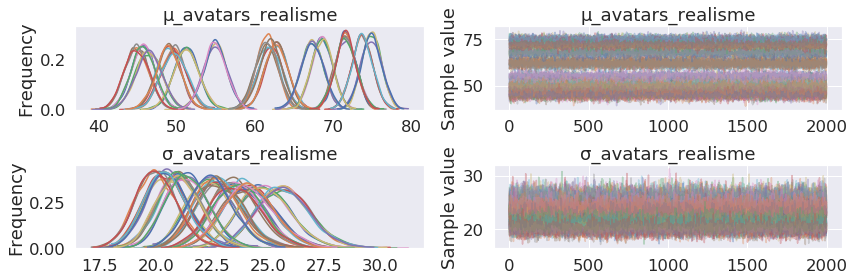

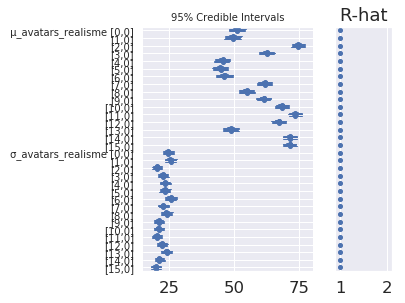

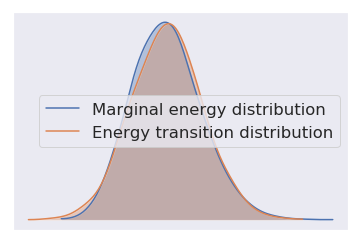

Gelman-Rubin  1.00001699792


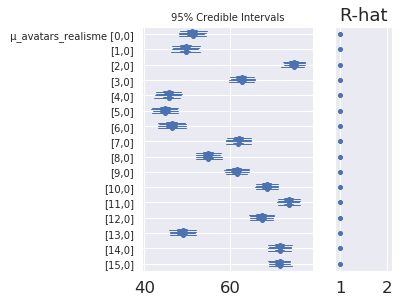

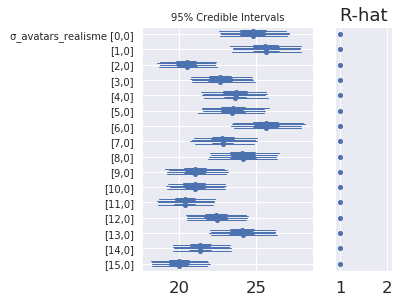

In [21]:
with pm.Model() as model_simple_realisme:
    # realisme
    ## priors
    μ_avatars_realisme = pm.Uniform('μ_avatars_realisme', 0, 100, shape=(num_avatar,1))
    σ_avatars_realisme = pm.HalfCauchy('σ_avatars_realisme', 25, shape=(num_avatar,1))
    
    ## obsevations
    obs_realisme = pm.Normal('obs_realisme', 
                        mu=μ_avatars_realisme, 
                        sd=σ_avatars_realisme, 
                        shape=(num_avatar, 1), 
                        observed=realisme_obs_data.reshape((num_avatar, -1)))
    
    
    trace = pm.sample(draws=2000, cores=4)
    
display(model_to_graphviz(model_simple_realisme))
summary(trace)
pm.plots.forestplot(trace, varnames=['μ_avatars_realisme'])
plt.show()
pm.plots.forestplot(trace, varnames=['σ_avatars_realisme'])
plt.show()

## Herarchical model

### Age

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_participant_bias_age, σ_avatars_age, μ_avatars_age]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:32<00:00, 107.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


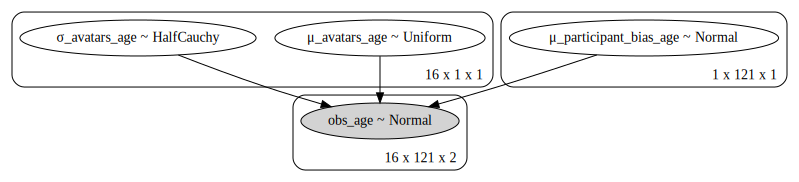

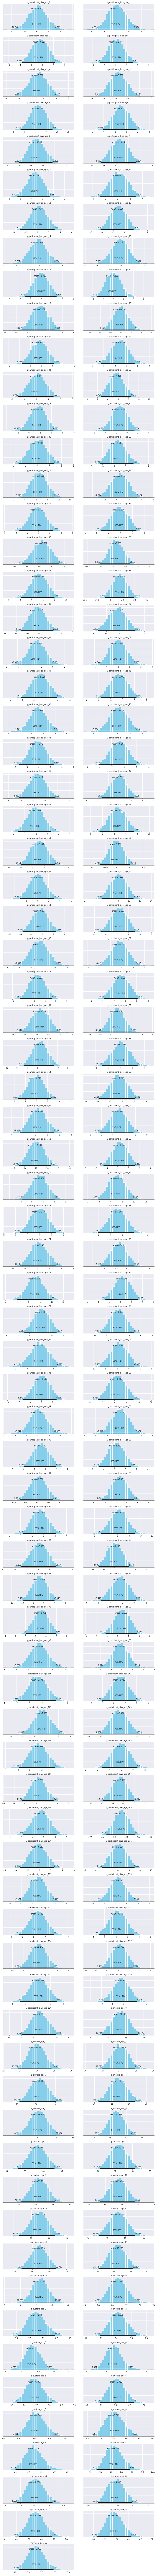

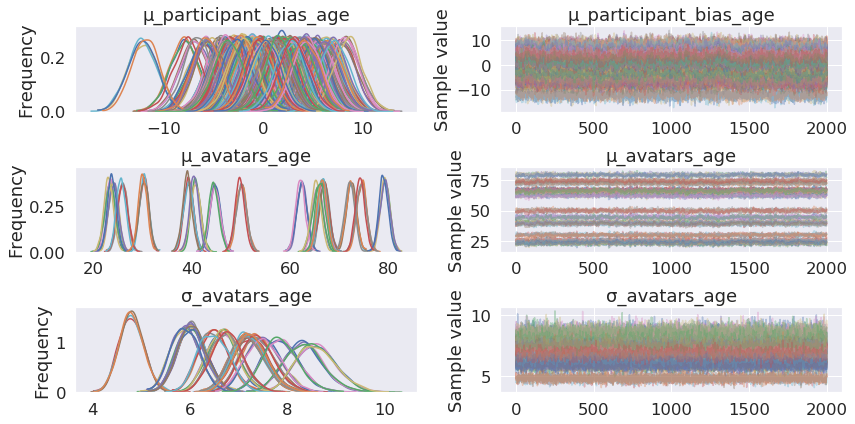

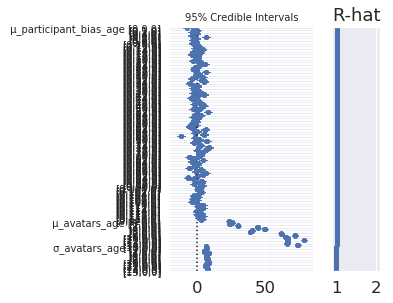

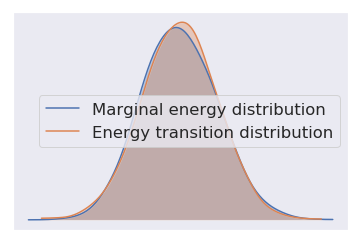

Gelman-Rubin  1.01529679103


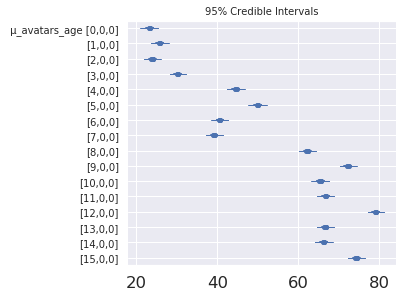

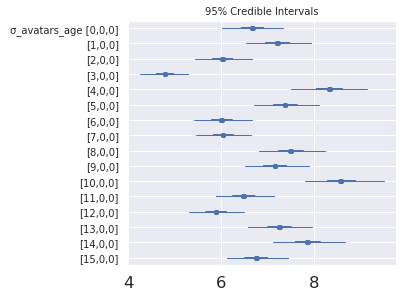

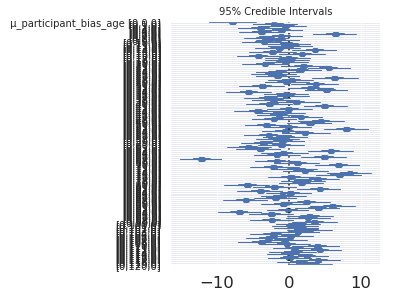

In [22]:
with pm.Model() as model_herarchical_age:
    # Age
    ## priors
    μ_avatars_age = pm.Uniform('μ_avatars_age', 0, 100, shape=(num_avatar, 1, 1))
    σ_avatars_age = pm.HalfCauchy('σ_avatars_age', 25, shape=(num_avatar, 1, 1))
    
    μ_participant_bias_age = pm.Normal('μ_participant_bias_age', mu=0, sd=10, shape=(1, num_participant, 1))
    
    
    obs_age = pm.Normal('obs_age',
                        mu=μ_avatars_age + μ_participant_bias_age,
                        sd=σ_avatars_age,
                        shape=(num_avatar, num_participant, 1),
                        observed=age_obs_data,
                       )
    
    trace = pm.sample(draws=2000, cores=4)
    
display(model_to_graphviz(model_herarchical_age))
summary(trace) 

pm.plots.forestplot(trace, varnames=['μ_avatars_age'], rhat=False, chain_spacing=0)
plt.savefig('Age moyen des avatars.png', dpi=220)
plt.show()
pm.plots.forestplot(trace, varnames=['σ_avatars_age'], rhat=False, chain_spacing=0)
plt.savefig('Variance de Age des avatars.png', dpi=220)
plt.show()
pm.plots.forestplot(trace, varnames=['μ_participant_bias_age'], rhat=False, chain_spacing=0)
plt.show()

trace_age = trace

#### Age avatar vs Age participant

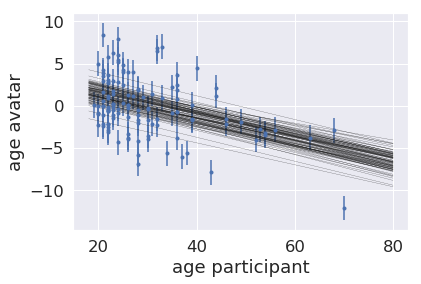

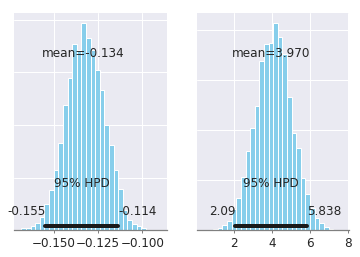

In [85]:
μ_age = np.squeeze(np.mean(trace_age['μ_participant_bias_age'],axis=0))
σ_age = np.squeeze(np.std(trace_age['μ_participant_bias_age'],axis=0))

age_participant = df.groupby('participant').age_participant.mean().values

plt.errorbar(x=age_participant, y=μ_age, yerr=σ_age, linestyle='', marker='.')
b, _, _, _ = np.linalg.lstsq(np.vstack((age_participant, np.ones_like(age_participant))).T, μ_age.T)

bs = []
for i in range(len(trace_age['μ_participant_bias_age'])):
    age = trace_age['μ_participant_bias_age'][i, 0, :, 0]

    b, _, _, _ = np.linalg.lstsq(np.vstack((age_participant, np.ones_like(age_participant))).T, age.T)
    if not (i%80):
        plt.plot(np.array([18, 80]), np.array([18, 80])*b[0] + b[1], 'k', lw=0.2)
    bs.append(b)
bs = np.stack(bs)
plt.xlabel('age participant')
plt.ylabel('age avatar')
plt.show()

_, axs = plt.subplots(1,2)
pm.plot_posterior(bs[:,0], ax=axs[0])
pm.plot_posterior(bs[:,1], ax=axs[1])
plt.show()

In [82]:
df_age = pd.DataFrame(np.squeeze(trace_age['μ_participant_bias_age'])[::4000, :])
df_age.columns = df.groupby('participant').age_participant.mean()
df_age.columns.name='participant_age'
df_age = df_age.melt(value_name='μ_participant_bias_age')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, participant_age, Intercept]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:12<00:00, 1322.86draws/s]
The acceptance probability does not match the target. It is 0.880048544325, but should be close to 0.8. Try to increase the number of tuning steps.


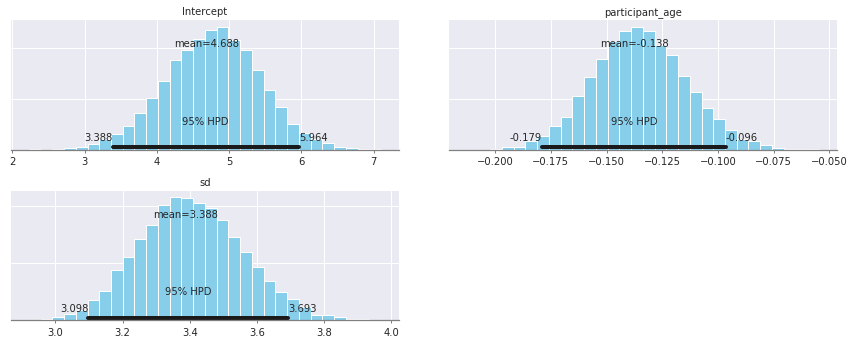

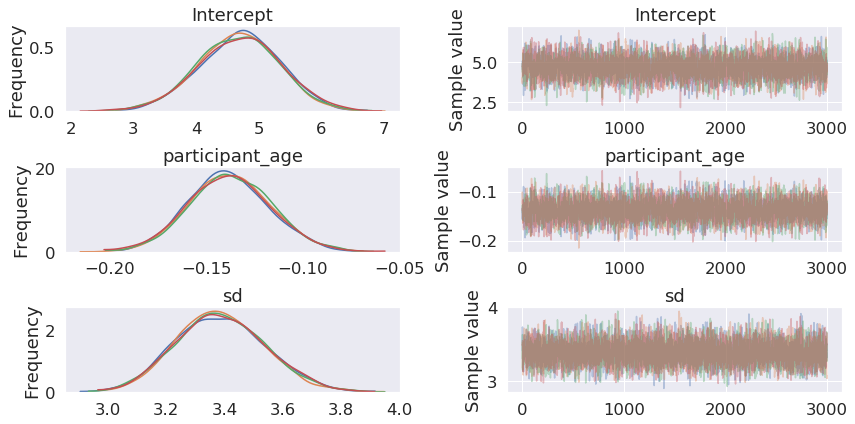

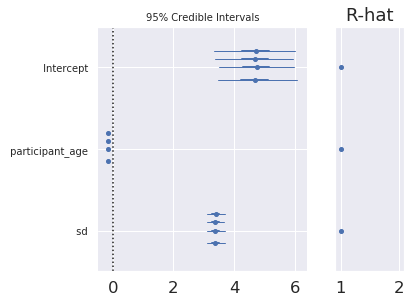

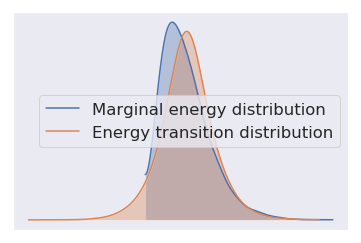

Gelman-Rubin  1.00064536836


<Figure size 432x288 with 0 Axes>

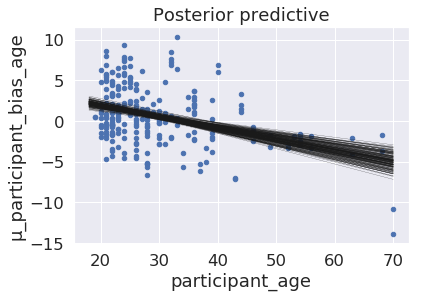

In [84]:
with pm.Model() as age_linear_regression:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    g = glm.GLM.from_formula('μ_participant_bias_age ~ participant_age', df_age)
    trace2 = pm.sample(3000, cores=4, tune=1000) # draw 3000 posterior samples using NUTS sampling
summary(trace2)

plt.figure()
df_age.plot.scatter('participant_age', 'μ_participant_bias_age')
pm.plot_posterior_predictive_glm(trace2, eval=np.array([18, 70]), samples=200, lm=lambda x, sample: sample['Intercept'] + sample['participant_age'] * x)
trace2_age = trace2

### Realisme

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_participant_bias_real, σ_avatars_real, μ_avatars_real]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:21<00:00, 468.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


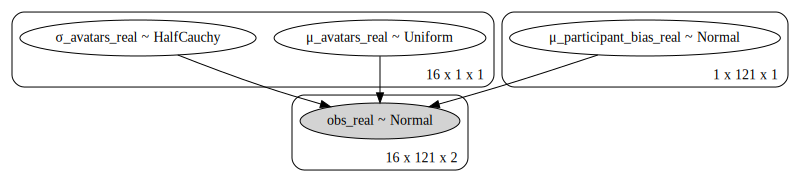

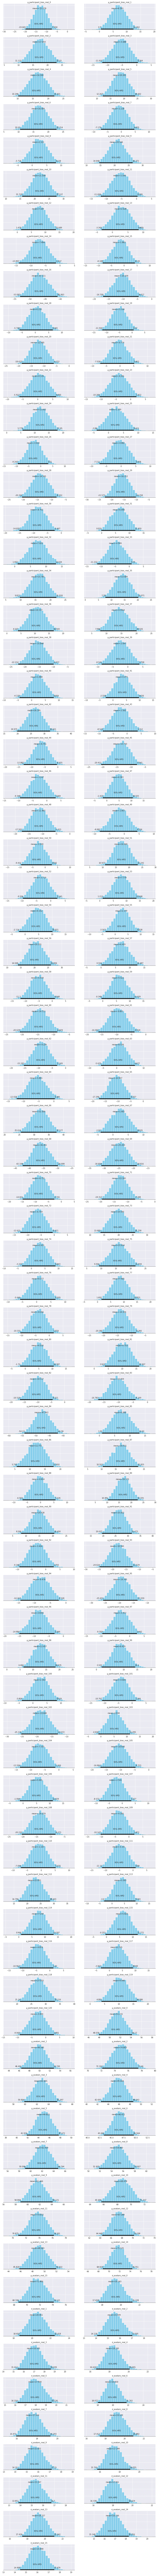

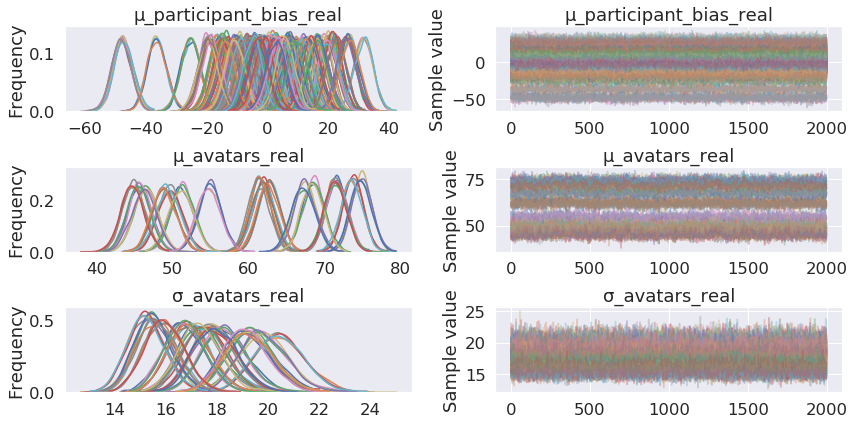

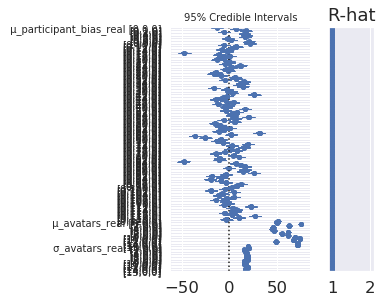

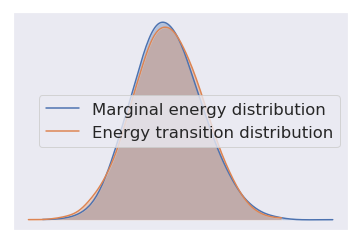

Gelman-Rubin  1.00336497361


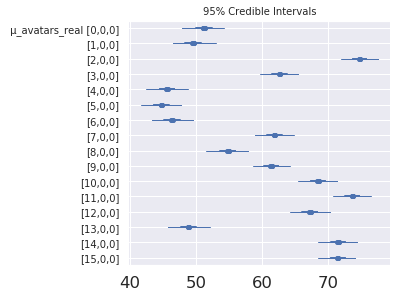

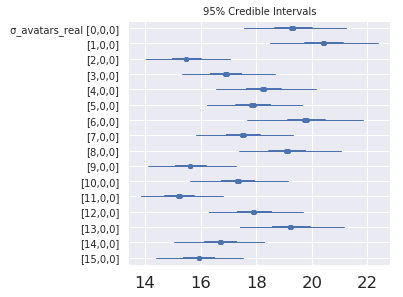

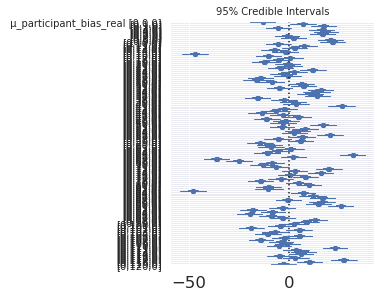

In [24]:
with pm.Model() as model_herarchical_real:
    # Age
    ## priors
    μ_avatars_real = pm.Uniform('μ_avatars_real', 0, 100, shape=(num_avatar, 1, 1))
    σ_avatars_real = pm.HalfCauchy('σ_avatars_real', 25, shape=(num_avatar, 1, 1))
    
    μ_participant_bias_real = pm.Normal('μ_participant_bias_real', mu=0, sd=10, shape=(1, num_participant, 1))
    
    
    obs_real = pm.Normal('obs_real',
                        mu=μ_avatars_real + μ_participant_bias_real,
                        sd=σ_avatars_real,
                        shape=(num_avatar, num_participant, 1),
                        observed=realisme_obs_data,
                       )
    
    trace = pm.sample(draws=2000, cores=4)
    
display(model_to_graphviz(model_herarchical_real))
summary(trace) 

pm.plots.forestplot(trace, varnames=['μ_avatars_real'], rhat=False, chain_spacing=0)
plt.savefig('Realisme moyen des avatars.png', dpi=220)
plt.show()
pm.plots.forestplot(trace, varnames=['σ_avatars_real'], rhat=False, chain_spacing=0)
plt.savefig('Variance du realisme des avatars.png', dpi=220)
plt.show()
pm.plots.forestplot(trace, varnames=['μ_participant_bias_real'], rhat=False, chain_spacing=0)
plt.show()

trace_real = trace

#### Realisme vs Age participant

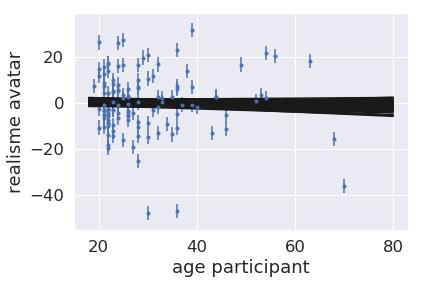

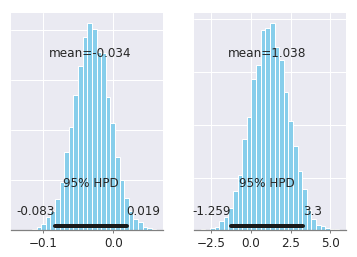

In [55]:
μ_real = np.squeeze(np.mean(trace_real['μ_participant_bias_real'],axis=0))
σ_real = np.squeeze(np.std(trace_real['μ_participant_bias_real'],axis=0))

age_participant = df.groupby('participant').age_participant.mean().values

plt.errorbar(x=age_participant, y=μ_real, yerr=σ_real, linestyle='', marker='.')
b, _, _, _ = np.linalg.lstsq(np.vstack((age_participant, np.ones_like(age_participant))).T, μ_real.T)

bs = []
for i in range(len(trace_real['μ_participant_bias_real'])):
    real = trace_real['μ_participant_bias_real'][i, 0, :, 0]

    b, _, _, _ = np.linalg.lstsq(np.vstack((age_participant, np.ones_like(age_participant))).T, real.T)
    if not (i%80):
        plt.plot(np.array([18, 80]), np.array([18, 80])*b[0] + b[1], 'k')
    bs.append(b)
bs = np.stack(bs)
plt.xlabel('age participant')
plt.ylabel('realisme avatar')
plt.show()

_, axs = plt.subplots(1,2)
pm.plot_posterior(bs[:,0], ax=axs[0])
pm.plot_posterior(bs[:,1], ax=axs[1])
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:12<00:00, 1281.79draws/s]


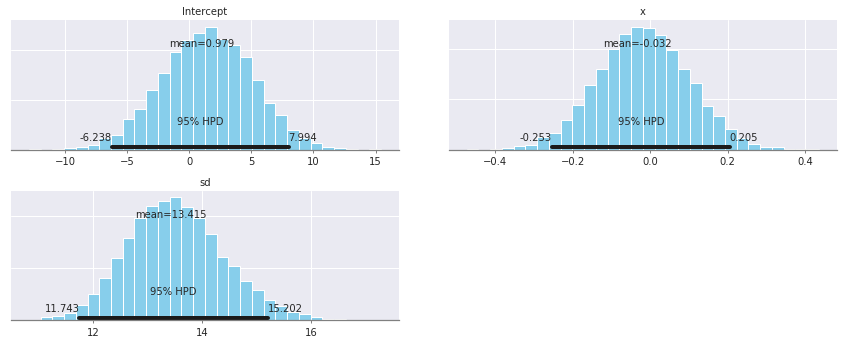

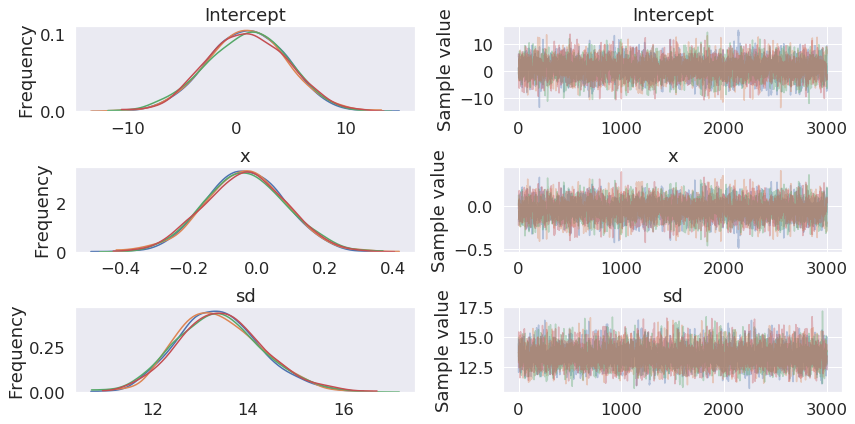

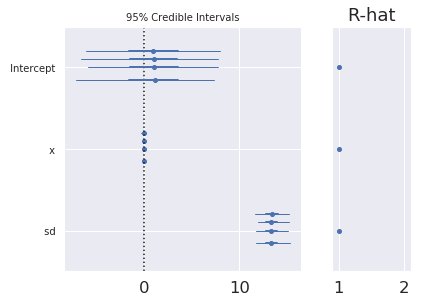

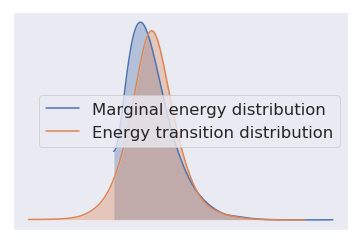

Gelman-Rubin  1.00052499295


<Figure size 432x288 with 0 Axes>

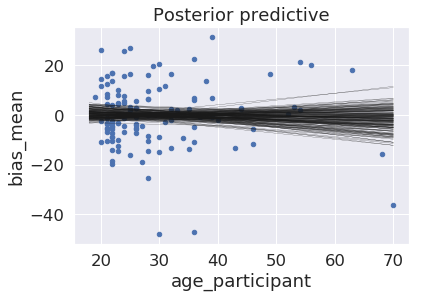

In [25]:
df_age_participant = pd.DataFrame(index=df.groupby('participant').age_participant.mean(), data=np.squeeze(np.mean(trace_real['μ_participant_bias_real'],axis=0)), columns=['bias_mean'])
df_age_participant = df_age_participant.reset_index(level=0)


with pm.Model() as realism_linear_regression:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    g = glm.GLM.from_formula('bias_mean ~ x', df_age_participant.rename(columns={'age_participant':'x'}))
    trace2 = pm.sample(3000, cores=4, tune=1000) # draw 3000 posterior samples using NUTS sampling
summary(trace2)
plt.figure()
df_age_participant.plot.scatter('age_participant', 'bias_mean')
pm.plot_posterior_predictive_glm(trace2, eval=np.array([18, 70]), samples=200)
trace2_real = trace2

#### Realisme vs sexe de l'avatar

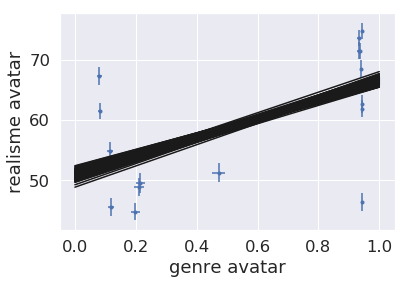

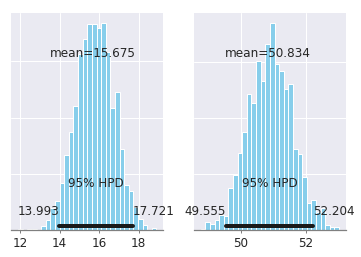

In [30]:
μ_real = np.squeeze(np.mean(trace_real['μ_avatars_real'],axis=0))
σ_real = np.squeeze(np.std(trace_real['μ_avatars_real'],axis=0))

μ_genre = np.squeeze(np.mean(trace_simple_genre['μ_avatars_genre'],axis=0))
σ_genre = np.squeeze(np.std(trace_simple_genre['μ_avatars_genre'],axis=0))

plt.errorbar(x=μ_genre, y=μ_real, xerr=σ_genre, yerr=σ_real, linestyle='', marker='.')
b, _, _, _ = np.linalg.lstsq(np.vstack((μ_genre, np.ones_like(μ_genre))).T, μ_real.T)

bs = []
for i in range(2000):
    real = stats.norm(loc=μ_real, scale=σ_real).rvs()
    genre = stats.norm(loc=μ_genre, scale=σ_genre).rvs()
    b, _, _, _ = np.linalg.lstsq(np.vstack((genre, np.ones_like(genre))).T, real.T)
    if not (i%20):
        plt.plot(np.array([0, 1]), np.array([0, 1])*b[0] + b[1], 'k')
    bs.append(b)
bs = np.stack(bs)
plt.xlabel('genre avatar')
plt.ylabel('realisme avatar')
plt.show()

_, axs = plt.subplots(1,2)
pm.plot_posterior(bs[:,0], ax=axs[0])
pm.plot_posterior(bs[:,1], ax=axs[1])
plt.show()

## identifying trolls

Text(0,0.5,'Spread from the sample mean')

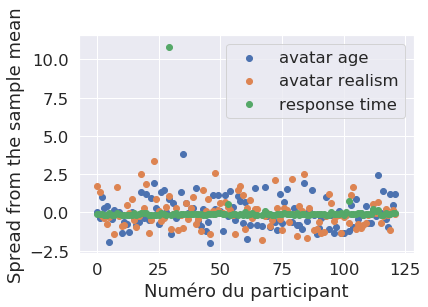

In [27]:
same_avatar_age_std = df.groupby(['participant', 'avatar']).age.std().groupby('participant').mean()
same_avatar_age_std = (same_avatar_age_std - same_avatar_age_std.mean())/same_avatar_age_std.std()

same_avatar_realisme_std = df.groupby(['participant', 'avatar']).realisme.std().groupby('participant').mean()
same_avatar_realisme_std = (same_avatar_realisme_std - same_avatar_realisme_std.mean())/same_avatar_realisme_std.std()


participant_response_time = df.groupby(['participant']).temps_de_reponse.mean()
participant_response_time = (participant_response_time - participant_response_time.mean())/participant_response_time.std()

plt.scatter(same_avatar_age_std.index, same_avatar_age_std.values )
plt.scatter(same_avatar_realisme_std.index, same_avatar_realisme_std.values)
plt.scatter(participant_response_time.index, participant_response_time.values)

plt.xlabel('Numéro du participant')
plt.legend(['avatar age', 'avatar realism', 'response time'])
plt.ylabel('Spread from the sample mean')


No apparent troll